In [48]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from tune_sklearn import TuneSearchCV, TuneGridSearchCV

import umap
import umap.plot

from itertools import product

from dask import bag, diagnostics

from pathlib import Path
import os, sys


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)


<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

In [2]:
# Import dataframe (id/path/label)
path_name = '../../data/PBC_dataset_normal_df_merged.csv'
df = leuko.load_df(path_name)

barca = df.copy()[df.origin=='barcelone']
munich = df.copy()[df.origin=='munich']
raabin = df.copy()[df.origin=='raabin']

df.head()

,img_path,label,label_2,origin,height,width,mean_brightness,mean_luminance
0,../../data/dataset/SNE/SNE_263049.jpg,SNE,SNE,barcelone,363,360,200.803423,0.783345
1,../../data/dataset/SNE/SNE_829664.jpg,SNE,SNE,barcelone,363,360,197.570620,0.766877
2,../../data/dataset/SNE/SNE_987578.jpg,SNE,SNE,barcelone,363,360,197.110430,0.765792
3,../../data/dataset/SNE/SNE_66862.jpg,SNE,SNE,barcelone,363,360,200.949015,0.783442
4,../../data/dataset/SNE/SNE_935764.jpg,SNE,SNE,barcelone,363,360,188.113246,0.724006


# Iteration 1: Barcelone

In [3]:
# Loading grayscaled images
dfile_bag = bag.from_sequence(barca.img_path.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1) 

[########################################] | 100% Completed | 58.4s


In [4]:
images_flat.shape

(16891, 32760)

In [5]:
#  Encoding the labels
le = preprocessing.LabelEncoder()
target = le.fit_transform(barca.label)
le.classes_

array(['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY',
       'SNE'], dtype=object)

# UMAP emdedding 

## Applying our UMAP model


In [6]:
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6, n_components=500).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 18min 41s, sys: 3min 22s, total: 22min 4s
Wall time: 5min 57s


## Train, test, split

In [7]:
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(embedding, target,
                                                   train_size = 0.8,
                                                   random_state = 42)

# Random Forest
## GridSearch CV with ray

In [54]:
def best_model_Ray_bayes(X_train, y_train, name, model):    
    '''run standard scaler and gridsearch CV pipeline on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''

    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params, early_stopping=False):

        GSCV = TuneSearchCV(model, params, 
                            search_optimization='bayesian',
                            n_trials=7,
                            early_stopping=early_stopping,
                            max_iters=10,
                            scoring = 'accuracy',
                            loggers=['csv'],
                            cv = 5, n_jobs=7, verbose=1)

        best_clf = GSCV.fit(X_train, y_train)

        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(f'Mean cross-validated accuracy score of the best_estimator:{best_score:.3f}')
        print(f'with {best_hyperparams} for {estimator}')
        table = best_clf.cv_results_
        results_cv[name] = table

        return estimator
        


    if name == 'LR':
        params = {'C' : tuple([0.001, 0.01, 0.1, 1.]),
                 'penalty' : tuple(['l1', 'l2'])} 
        best_model_stack.append(grid_csv(params))
              
    if name == 'KNN':
        params = {'n_neighbors' : tuple(np.arange(5, 100, 5)),
                 'weights' : tuple(['uniform', 'distance']),
                 'algorithm' : tuple(['ball_tree', 'kd_tree', 'brute', 'auto'])} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : tuple(['linear', 'poly', 'rbf', 'sigmoid']),
                 'C' : tuple(np.arange(0.01, 1, 0.02))} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : tuple(np.arange(5, 200, 10)),
                  'max_features' : tuple(['auto', 'sqrt', 'log2']),
                  'max_depth' : tuple(np.arange(3, 15, 1)),
                  'min_weight_fraction_leaf': tuple(np.arange(0, 0.6, 0.2))
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [55]:
model_GSCV = {}
model_GSCV['LR'] = LogisticRegression(class_weight="balanced", solver="liblinear")
model_GSCV['KNN'] = KNeighborsClassifier()
model_GSCV['SVM'] = SVC()
model_GSCV['RF'] = RandomForestClassifier(class_weight='balanced')

## UMAP embedding

In [56]:
def plot_conf_mat(y_true, y_pred, name):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (6,4))
    sns.set(font_scale=0.8)
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8}, fmt='g')
    plt.title(name)
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names = le.classes_))

In [63]:
results_best_model_bayes = {}
scoring_bayes = {}

for name, model in model_GSCV.items():
    scores = best_model_Ray_bayes(X_train_umap, y_train_umap, name, model)
    results_best_model_bayes[name] = scores[0][0]

Mean cross-validated accuracy score of the best_estimator:0.646
with {'n_estimators': 65, 'max_features': 'auto', 'max_depth': 5, 'min_weight_fraction_leaf': 0.0} for RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=65)


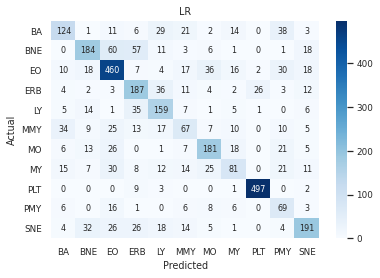

              precision    recall  f1-score   support

          BA       0.60      0.50      0.54       249
         BNE       0.66      0.54      0.59       341
          EO       0.70      0.74      0.72       618
         ERB       0.54      0.64      0.59       290
          LY       0.55      0.68      0.61       234
         MMY       0.40      0.34      0.37       197
          MO       0.66      0.65      0.65       278
          MY       0.52      0.36      0.43       224
         PLT       0.94      0.97      0.96       512
         PMY       0.35      0.60      0.44       115
         SNE       0.70      0.60      0.64       321

    accuracy                           0.65      3379
   macro avg       0.60      0.60      0.59      3379
weighted avg       0.66      0.65      0.65      3379



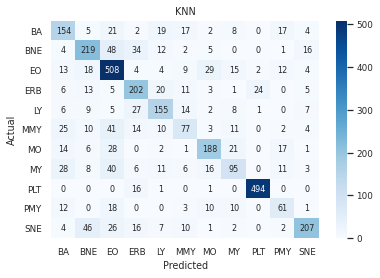

              precision    recall  f1-score   support

          BA       0.58      0.62      0.60       249
         BNE       0.66      0.64      0.65       341
          EO       0.69      0.82      0.75       618
         ERB       0.63      0.70      0.66       290
          LY       0.64      0.66      0.65       234
         MMY       0.51      0.39      0.44       197
          MO       0.72      0.68      0.70       278
          MY       0.56      0.42      0.48       224
         PLT       0.95      0.96      0.96       512
         PMY       0.50      0.53      0.51       115
         SNE       0.82      0.64      0.72       321

    accuracy                           0.70      3379
   macro avg       0.66      0.64      0.65      3379
weighted avg       0.70      0.70      0.69      3379



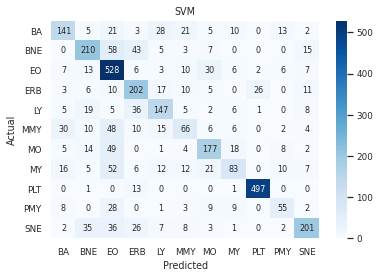

              precision    recall  f1-score   support

          BA       0.65      0.57      0.61       249
         BNE       0.66      0.62      0.64       341
          EO       0.63      0.85      0.73       618
         ERB       0.59      0.70      0.64       290
          LY       0.62      0.63      0.63       234
         MMY       0.46      0.34      0.39       197
          MO       0.67      0.64      0.65       278
          MY       0.59      0.37      0.46       224
         PLT       0.94      0.97      0.96       512
         PMY       0.57      0.48      0.52       115
         SNE       0.78      0.63      0.69       321

    accuracy                           0.68      3379
   macro avg       0.65      0.62      0.63      3379
weighted avg       0.68      0.68      0.68      3379



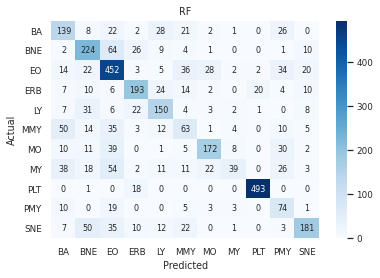

              precision    recall  f1-score   support

          BA       0.49      0.56      0.52       249
         BNE       0.58      0.66      0.61       341
          EO       0.62      0.73      0.67       618
         ERB       0.69      0.67      0.68       290
          LY       0.60      0.64      0.62       234
         MMY       0.34      0.32      0.33       197
          MO       0.74      0.62      0.67       278
          MY       0.65      0.17      0.27       224
         PLT       0.96      0.96      0.96       512
         PMY       0.36      0.64      0.46       115
         SNE       0.75      0.56      0.65       321

    accuracy                           0.65      3379
   macro avg       0.61      0.59      0.59      3379
weighted avg       0.66      0.65      0.64      3379



In [64]:
for name, model in results_best_model_bayes.items():
    y_pred_umap = model.predict(X_test_umap)
    plot_conf_mat(y_test_umap, y_pred_umap, name)